## Analyze A/B Test Results

## Table of Contents
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='probability'></a>
### Part I - Probability

In [1]:
# import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

In [2]:
# read in dataset
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# number of rows
print(df.shape[0])

# number of unique users
print(df.user_id.nunique())

294478
290584


In [4]:
# proportion of users converted
(df.converted == 1).mean()

0.11965919355605512

In [5]:
# the number of times the new_page and treatment don't match.
x1 = df.query('group == "treatment" and landing_page != "new_page"').shape[0]
x2 = df.query('group == "control" and landing_page != "old_page"').shape[0]
x1 + x2

3893

In [6]:
# look at data overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [7]:
# subset useful data from flawed data
df2 = df.query('group == "treatment" and landing_page == "new_page"')
df2 = df2.append(df.query('group == "control" and landing_page == "old_page"'))
df2.shape

(290585, 5)

In [8]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [9]:
# unique user_ids in df2
df2.user_id.nunique()

290584

In [10]:
# check for duplicates
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [11]:
# find duplicates
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
# drop duplicate
df2.drop(1899, inplace=True)
df2.shape

(290584, 5)

In [13]:
# probability of an individual converting regardless of the page
df2['converted'].mean()

0.11959708724499628

In [14]:
# probability of control group conversion
control_df = df2.query('group == "control"')
control_df['converted'].mean()

0.1203863045004612

In [15]:
# probability of treatment group conversion
treatment_df = df2.query('group == "treatment"')
treatment_df['converted'].mean()

0.11880806551510564

In [16]:
# probability that an individual received the new page
df[df['landing_page'] == "new_page"].shape[0] / df.shape[0]

0.5

#### Probability Results
> <div>
    Conversion proportions:
    <br>control group = .1204
    <br>treatment group = .1188
    <br>overall: .1196
</div>

The data shows that the probability of conversion for the treatment group is less than the control group, so we don't have sufficient evidence to show that the new page is better.

In [17]:
obs_diff = (treatment_df['converted'] == 1).mean() - (control_df['converted'] == 1).mean()
obs_diff

-0.0015782389853555567

<a id='ab_test'></a>
### Part II - A/B Test

`1.` Null and alternative hypothesis. Assume old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.
<div align="center">$H_{0}$: $p_{old}$ >= $p_{new}$ <br>
    $H_{1}$: $p_{old}$ < $p_{new}$</div>

`2.` Assume: under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

In [18]:
# conversion rate for p_new under the null
p_new = df2.converted.mean()
p_new

0.11959708724499628

In [19]:
# conversion rate for p_old under the null
p_old = df2.converted.mean()
p_old

0.11959708724499628

In [20]:
# number of individuals in treatment group
n_new = treatment_df.shape[0]
n_new

145310

In [21]:
# number of individuals in the control group
n_old = control_df.shape[0]
n_old

145274

In [22]:
# simulate n_new transactions with a conversion rate of p_new under the null
new_page_converted = np.random.choice(2, size=n_new, p=[1 - p_new, p_new])

In [23]:
# simulate n_old transactions with a conversion rate of p_old under the null
old_page_converted = np.random.choice(2, size=n_old, p=[1 - p_old, p_old])

In [24]:
# p_new - p_old for simulated values
new_page_converted.mean() - old_page_converted.mean()

0.0004178080630015818

In [25]:
# create 10,000 p_new - p_old values using the same simulation process above
p_diffs = []
for i in range(10000):
    new_pg_conv = np.random.choice(2, size=n_new, p=[1 - p_new, p_new])
    old_pg_conv = np.random.choice(2, size=n_old, p=[1 - p_old, p_old])
    diff = new_pg_conv.mean() - old_pg_conv.mean()
    p_diffs.append(diff)

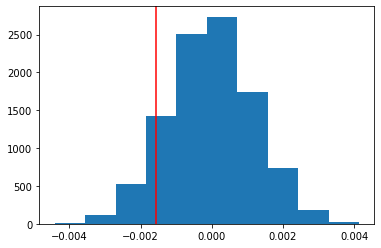

In [26]:
# histogram of p_diffs
plt.hist(p_diffs);
plt.axvline(obs_diff, c='r')

In [27]:
# proportion of the p_diffs are greater than the actual difference observed
(p_diffs > obs_diff).mean()

0.904

#### A/B testing results
The calculated p-value is 0.9. Considering that the alpha set for this experiment is 0.05, and p-val > 0.05, we fail to reject the null. IE the new page does not result in more conversions than the old page.

#### Analysis with statsmodels

In [28]:
import statsmodels.api as sm

In [29]:
convert_old = control_df.converted.mean()
convert_new = treatment_df.converted.mean()
n_old = control_df.shape[0]
n_new = treatment_df.shape[0]

In [30]:
# compute test statistic and p-value
sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new]) # returns (stat, pval)

(0.0032875796753531767, 0.9973768956597913)

#### Statsmodels results
The z-score of 0.0033 is close to 0, indicating that the change in number of conversions between the control and treatment group are very close, almost the same. The p-value of 0.997 indicates that we fail to reject the null. These findings are consistent with the work we did above.

<a id='regression'></a>
### Part III - A regression approach

`1.` **Logistic Regression** will be used here because the model will be predicting a categorical response.

The goal here is to use **statsmodels** to fit a logistic regression model to see if there is a significant difference in conversion based on which page a customer receives.

In [31]:
# create intercept column
df2['intercept'] = 1

In [32]:
# create dummy columns
df2[['temp', 'ab_page']] = pd.get_dummies(df2['group'])

In [33]:
# we only need one
df2.drop('temp', axis=1, inplace=True)

In [34]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


In [35]:
# use statsmodels to instantiate regression model on the two columns just created 
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 14 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        10:22:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

#### Regression model results
**p-value** = 0.190

This p-value is different from the p-value found in part II. In part II, we were investigating whether there is a difference in conversions between the old and new pages, so the null was that the old page does equally as well or better than the new page. In this section, we are trying to determine if there is a relationship between the page and conversions, so the null is that there is no relationship. They are inherently different.

From the analysis we've done so far, we haven't been able to prove that the new page results in more conversions, but we might be able to find relationships between other variables that might influence the conversion rates. 

#### Does it appear that country had an impact on conversion? 

In [37]:
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [38]:
df2 = df2.merge(countries_df, on='user_id')

In [ ]:
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])

logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'CA', 'UK']])
results = logit_mod.fit()
results.summary()

#### Countries results
The p-values for the countries suggest that none of these values are statistically significant when predicting conversion.

#### Analysis of country-page interaction

In [ ]:
# define interaction terms
df2['UK_new'] = df2['UK'] * df2['ab_page']
df2['US_new'] = df2['US'] * df2['ab_page']

In [ ]:
# fit model
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'UK', 'US', 'ab_page', 'UK_new', 'US_new']])
results = logit_mod.fit()
results.summary()

#### Interaction Conclusion

All p-values are greater than 0.05, so we fail to reject the null. There is no evidence that the new page performs better even when considering interactions between page and country.

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'analyze_ab_test_results.ipynb'])